# Group Assignment 1: Human Activity Detection
In this assignment you will create you own dataset for classification. You will explore which ML algorithms are best to classify this and you will present your best solution. 

- Create your own dataset for custom human motions using Phyphox
- There should be at least 3 distinct types of motions
- The motions should be different to the ones used in the UCI dataset (Not: walking, sitting, standing, laying, stairs)
- Follow the steps and answer the questions given in this notebook

### Generating your dataset:

For this assignment you will create your own dataset of motions that you collect with an Accelerometer and Gyroscope. For this you can use your phone as a sensor.
To be able to collect your data you can best use an app called [phyphox](https://phyphox.org/), this is a free app available in app stores. This app can be configured to acces your sensordata, sample it as given frequency's. you can set it up te have experiment timeslots, and the data with a timestamp can be exported to a needed output format.

![](https://phyphox.org/wp-content/uploads/2019/06/phyphox_dark-1024x274.png)

When you installed the app you can setup a custum experiment by clicking on the + button. Define an experiment name, sample frequency and activate the Accelerometer and Gyroscope. Your custom experiment will be added, you can run it pressing the play button and you will see sensor motion. Pressing the tree dots (...) lets you define timed runs, remote access and exporting data.

Phyphox will generate 2 files with sensor data, one for the Accelerometer and one for the Giro. Both files will have timestamps which might not match the recorded sensor data for each sensor. Please, preprocess and merge the files for using it as your dataset for training, testing and deploying your own supervised learning model.

### steps

With your own generated dataset the similar sequence of steps should be taken to train your model.

These are the generic steps to be taken
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.
9. Additional Questions


---
In the Notebook this structure is used for dividing the different steps, so make sure you do the implementation and analisis at these location in the notebook. 

You may add additinal code blocks, but keep the seperation of the given structure.

At the end of each block summarize / comment / conclude your current step in the given textblocks.




```
Roel van der Leest // 4910087
Jari van hoof // 4938135
Wout van der zanden // 4845250
```


# 1. Frame the problem and look at the big picture
*Describe the problem at hand and explain your approach*

### Problem Description
The goal of this assignment is to develop a machine learning model capable of recognizing specific human activities based on sensor data. We will distinguish between three gestures using data collected from a smartphone's accelerometer and gyroscope.

### Selected Activities
We have chosen three motions that involve different arm trajectories:
1.  **Drawing the letter 'O':** A continuous circular motion performed in the air.
2.  **Throwing a ball:** A rapid, linear acceleration followed by a deceleration.
3.  **Opening a door:** A reach-and-pull or push-and-turn motion.

### Approach & Methodology
*   **Data Collection:** We will use the Phyphox app to record 3-axis Accelerometer and Gyroscope data.
*   **Hardware Consistency:** To eliminate overfitting to one specific device its sensors, we will use 2 different smartphones for all data collection.
*   **Bias Mitigation:** To ensure our model learns the motion rather than a specific person's movement style, we will have each group member perform 10 movements with one phone, following 10 times the same movement with the other phone. This results in total 60 samples per activity which is build up from 2 different phones and 3 different people.


# 2. Get the data.

### Data Collection Protocol
As explained above, to ensure good data and minimize bias we have established the following protocol:
*   **Device:** Two phones will be used for all recordings to eliminate hardware sensor variance.
*   **Participants:** each group member will perform the motions to prevent the model from overfitting to a single person's movement style.
*   **Volume:** We aim for 20 samples per person per movement with 10 samples on each phone.
*   **Sampling:** We will use fixed time windows in Phyphox to ensure consistent data length for each sample.
*   **Phone Placement:** The phone will be held in the right hand in a predefined orientation for all recordings.
*   **Data saving:** For our own clarity data will be saved under /[activity_name]/[phone_name]/[person_name]. So for example: a sample measured on jari's phone with the activity 'drawing an O' performed by roel will be saved under /letter O movement data/phone jari/test roel/

### The Classes
We will classify the following 3 activities:

#### 1. Opening a Door
*   **Action:** Miming the action of reaching for a handle, turning/pushing, and returning.
*   **Start Position:** Hands beside the body.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Hands beside the body.
*   **Phone Orientation:** [TODO: Add image of phone grip]

#### 2. Drawing the Letter 'O'
*   **Action:** Drawing a large circle in the air.
*   **Start Position:** Hands in front of the body at the top of the 'O'.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Same as start position (completing the loop).
*   **Phone Orientation:** [TODO: Add image of phone grip]

#### 3. Throwing a Ball
*   **Action:** Miming an overhand throw.
*   **Start Position:** Hands beside the body.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Hand at the top of the arc, after the "release".
*   **Phone Orientation:** [TODO: Add image of phone grip]

<!-- ### Data Loading & Merging Strategy

**Addressing your question:** *"Shouldn't we separate by folder?"*

We **are** separating the data logically, but storing it in a single efficient structure for Machine Learning.

**1. The `Activity` Label:**
Instead of creating separate variables for each folder, we add an `Activity` column.
*   The script automatically detects if a sample is "Door Movement", "Letter O", or "Throwing Ball" based on the folder path.
*   This creates the **Labels ($y$)** required for supervised learning.

**2. The `Sample_ID`:**
*   We assign a unique `Sample_ID` to every 5-second recording found.
*   This allows us to distinguish between individual movements (e.g., "Door Movement #1", "Door Movement #2") within the large dataset.

**Why this format?**
This "Long Format" (Time-Series) is the standard starting point. In **Step 4**, we will group by `Sample_ID` to calculate features (e.g., mean acceleration, max gyro) for each unique movement, creating the final training set. -->

# 3. Explore the data to gain insights.

*Explore the data in any possible way, visualize the results (if you have multiple plots of the same kind of data put them in one larger plot)*

After conducting all the data collection with pyphox all the data was inside a Zip file, plus it included unnecessary meta data. Manually unzipping and cleaning this data would be very time consuming. Therefore, we used a python script that automatically unzips all files and removes unnecessary meta data.

In [12]:
import os
import zipfile
import shutil

def unzip_and_clean(target_directory):
    
    if not os.path.exists(target_directory):
        print(f"Directory not found: {target_directory}")
        return

    # Walk through all directories recursively
    for root, dirs, files in os.walk(target_directory):
        # Check all files in the current directory
        for filename in files:
            file_path = os.path.join(root, filename)

            # Check if it's a zip file
            if filename.lower().endswith('.zip'):
                # Create a directory name based on the zip file (removing .zip extension)
                extract_folder_name = os.path.splitext(filename)[0]
                extract_path = os.path.join(root, extract_folder_name)
                
                # Unzip
                try:
                    with zipfile.ZipFile(file_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                    
                    # Remove 'meta' directory if it exists
                    meta_dir = os.path.join(extract_path, 'meta')
                    if os.path.exists(meta_dir) and os.path.isdir(meta_dir):
                        shutil.rmtree(meta_dir)
                        
                    os.remove(file_path)
                except zipfile.BadZipFile:
                    print(f"Error: {filename} is a bad zip file.")
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

if __name__ == "__main__":
    # Base directory containing all movement data folders
    base_dir = r"C:\Users\roelv\Documents\Machine Learning\AIS\assignment 1"
    
    # Process all movement data directories
    movement_types = ["Door movement data", "letter O movement data", "throwing ball movement data"]
    
    for movement_type in movement_types:
        target_dir = os.path.join(base_dir, movement_type)
        if os.path.exists(target_dir):
            print(f"Processing: {movement_type}")
            unzip_and_clean(target_dir)
    
    print("Done!")


Processing: Door movement data
Processing: letter O movement data
Processing: throwing ball movement data
Done!


After succesfully unzipping and cleaning the data, we load all the data files into a single pandas DataFrame. Each file is labeled with its corresponding activity based on the folder structure.

In [13]:
import pandas as pd
import os

def get_label_from_path(path):
    path_lower = path.lower()
    if 'door' in path_lower:
        return 'Door Movement'
    elif 'letter o' in path_lower:
        return 'Letter O'
    elif 'ball' in path_lower or 'throw' in path_lower:
        return 'Throwing Ball'
    return 'Unknown'

def load_and_merge_data(base_dir):
    all_data = []
    sample_id_counter = 1
    
    # Walk through all folders
    for root, dirs, files in os.walk(base_dir):
        # We only care about folders that contain both sensor files
        if 'Accelerometer.csv' in files and 'Gyroscope.csv' in files:
            try:
                # 1. Construct file paths
                acc_path = os.path.join(root, 'Accelerometer.csv')
                gyro_path = os.path.join(root, 'Gyroscope.csv')
                
                # 2. Load the data
                df_acc = pd.read_csv(acc_path)
                df_gyro = pd.read_csv(gyro_path)
                
                # 3. Rename columns to avoid confusion after merge
                # renaming for clarity
                df_acc = df_acc.rename(columns={
                    df_acc.columns[0]: 'Time', 
                    df_acc.columns[1]: 'Acc_X', 
                    df_acc.columns[2]: 'Acc_Y', 
                    df_acc.columns[3]: 'Acc_Z'
                })
                
                df_gyro = df_gyro.rename(columns={
                    df_gyro.columns[0]: 'Time', 
                    df_gyro.columns[1]: 'Gyro_X', 
                    df_gyro.columns[2]: 'Gyro_Y', 
                    df_gyro.columns[3]: 'Gyro_Z'
                })
                
                # 4. Sort by time (required for merge_asof)
                df_acc = df_acc.sort_values('Time')
                df_gyro = df_gyro.sort_values('Time')
                
                # 5. Merge: Align Gyro data to the nearest Accelerometer timestamp
                # This handles the mismatched time frames/frequencies
                df_merged = pd.merge_asof(df_acc, df_gyro, on='Time', direction='nearest')
                
                # 6. Add Metadata
                df_merged['Activity'] = get_label_from_path(root) ## Note in machine learning models don't use string labels, this is only for our clarity for now.
                                                                  ## in chapter 4 we will convert these integers.
                df_merged['Sample_ID'] = sample_id_counter
                
                all_data.append(df_merged)
                sample_id_counter += 1
                
            except Exception as e:
                print(f"Error processing {root}: {e}")
                
    # Combine all samples into one big DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()

# Run the loading function
# We use '.' to search in the current directory and subdirectories
df_final = load_and_merge_data('.')

# Display results
print(f"Successfully loaded {len(df_final)} data points.")
print(f"Total unique samples (recordings): {df_final['Sample_ID'].nunique()}")
print("\nClass distribution:")
print(df_final['Activity'].value_counts())

# Show the first few rows
df_final.head()

Successfully loaded 45096 data points.
Total unique samples (recordings): 180

Class distribution:
Activity
Throwing Ball    15052
Letter O         15048
Door Movement    14996
Name: count, dtype: int64


,Time,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Activity,Sample_ID
0,-0.001773,9.166488,-3.286116,2.056723,0.310439,-0.062838,0.070347,Door Movement,1
1,0.018317,9.422306,-3.262615,2.197879,0.362224,-0.108883,0.053720,Door Movement,1
2,0.038407,9.295220,-3.129093,1.997147,0.347363,-0.165629,0.053675,Door Movement,1
3,0.058497,9.314381,-3.121459,2.042054,0.297007,-0.155002,0.038126,Door Movement,1
4,0.078587,9.304651,-3.115471,2.310296,0.324873,-0.132150,0.095936,Door Movement,1


*Script Explanation:*

- **Single DataFrame (long format):** We combine all recordings into one DataFrame so analysis, plotting, filtering, and later feature extraction are simple and consistent. A single table lets us easily group by recording Sample_ID and activity.

- **`Sample_ID`:** Each folder contains one recording (one activity). We assign a unique `Sample_ID` to every recording so we can treat each gesture as one sample later. During feature extraction we will group by Sample_ID

- **Merging accelerometer and gyroscope:** Phyphox exports two separate files per recording (Accelerometer.csv and Gyroscope.csv) with their own timestamps and sampling jitter. We use `pd.merge_asof` to align them: it matches each accelerometer timestamp with the nearest gyroscope timestamp. This is preferred because it preserves the main timeline (we merge onto `Time` from one sensor). and it deals robustly with slightly different sampling rates.


# 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

prepare your data, is it normalized? are there outlier? Make a training and a test set.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

### Data preperation

Our raw data is a Time-Series: for every single "Door Opening" movement, we have around 250 sensor readings (e.g., 5 seconds at 50Hz = 250 rows).

Most standard Machine Learning algorithms cannot handle raw time-series data directly. They expect a different format where:
*   1 Row = 1 Sample (one complete gesture)
*   Columns= Features describing that gesture

To solve this, We group all the sensor readings for a single `Sample_ID` and calculate summary statistics (like the average acceleration). This compresses the time-series into a single "fingerprint" for that movement. 

### Feature selection

At first we decided to use mean, std, min, max and range for each of the 6 sensor axes (Acc_X, Acc_Y, Acc_Z, Gyro_X, Gyro_Y, Gyro_Z). To this we would also add the magnitude features for both sensors. This resulted in 36 features per sample. The correlation matrix however showed us that a lot of features were highly correlated. Therefore, we decided to drop some features and only keep mean, std and range for both sensors. and for the magnitude features we only kept mean and std. This resulted in a total of 22 features. The correleation matrix of this setup looked like this:

![image.jpeg](./images/correlation%20matrix%20v1.jpeg)

By looking at the correlation matrix above we concluded the following two things:

* we initially thought using the magnitude would be usefull because if you hold the phone slightly differently (rotated), the X, Y, and Z values change completely, but the total magnitude of the acceleration remains the same. However as can be seen in the correlation matrix above, the magnitude features are highly correlated. Therefore, we decided to drop them.

* the range and std features are also highly correlated. However, we decided to keep both because they capture slightly different aspects of the motion. The std captures how much the movement on average varies around the mean, while the range captures the total spread between the minimum and maximum values. We believe both could be relevant for distinguishing between our chosen activities.


This ended us up with 18 features consisting of:
*   **Mean & Standard Deviation:** Captures the average intensity and how much the movement varies.
*   **Range:** Captures the extremes of the motion (e.g., the peak acceleration during a throw).

the correlation matrix of this setup looked like this:

![image.png](./images/correlation%20matrix%20v2.png)

as shown above the correlation between the range and std is especially high for the gyroscope's x,y,z features. whilst for the acceleration this is only the case for the x and y features. Therefore we decided to drop the range features for these. And only keep the std and range for the acceleration z axis. since the correlation between for this axis is lower.

This ended us up with 13 features consisting of:
*   **Mean & Standard Deviation:** Captures the average intensity and how much the movement varies.
*   **Range:** Captures the extremes of the motion (e.g., the peak acceleration during a throw), only applied to Acc_Z.

the correlation matrix of this final setup is shown a bit below in the correlation analysis section.

**Now finally below the code preparing the data and extracting the features can be seen below:**




In [37]:
def extract_features(df):
    # Group by Sample_ID and Activity (Activity is constant for a sample)
    grouped = df.groupby(['Sample_ID', 'Activity'])
    
    features = []
    labels = []
    
    for (sample_id, activity), group in grouped:
        # Extract raw sensor columns
        sensor_cols = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
        
        sample_features = {}
        
        # Calculate stats for each axis
        for col in sensor_cols:
            sample_features[f'{col}_mean'] = group[col].mean()
            sample_features[f'{col}_std'] = group[col].std()
        ## only allow range feature for Z axis to reduce feature correlation
            if col == 'Acc_Z' :
                sample_features[f'{col}_range'] = group[col].max() - group[col].min()

        ## -- commend out since we dropped magnitude features for now -- ##
        # Acc Magnitude = sqrt(x^2 + y^2 + z^2)
        # acc_mag = np.sqrt(group['Acc_X']**2 + group['Acc_Y']**2 + group['Acc_Z']**2)
        # sample_features['Acc_Mag_mean'] = acc_mag.mean()
        # sample_features['Acc_Mag_std'] = acc_mag.std()
        
        # gyro_mag = np.sqrt(group['Gyro_X']**2 + group['Gyro_Y']**2 + group['Gyro_Z']**2)
        # sample_features['Gyro_Mag_mean'] = gyro_mag.mean()
        # sample_features['Gyro_Mag_std'] = gyro_mag.std()
        ## --------------------------------------------------------- ##

        features.append(sample_features)
        labels.append(activity)
        
    return pd.DataFrame(features), pd.Series(labels)

### Applying Feature Extraction
Now that we have defined our function, we apply it to our dataset. This transforms our long time-series data into a dataset where each row represents a single motion sample with the extracted features.

In [39]:
# Apply feature extraction
X_raw, y_raw = extract_features(df_final)
print(f"Feature extraction complete. New shape: {X_raw.shape}")

Feature extraction complete. New shape: (180, 13)


### Correlation Analysis
to check for redundant features we plot a heatmap of the correlation matrix.

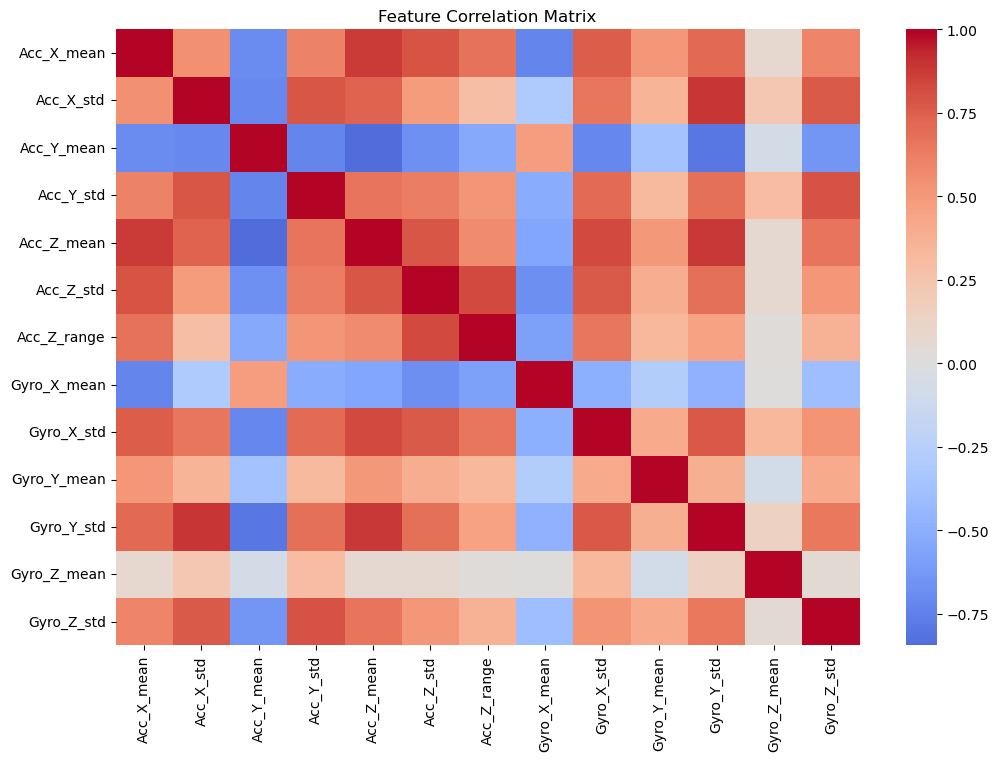

Number of highly correlated feature pairs (>0.85): 3
Top 5 pairs and their correlation:
Acc_X_mean & Acc_Z_mean: 0.875
Acc_X_std & Gyro_Y_std: 0.890
Acc_Z_mean & Gyro_Y_std: 0.879


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = X_raw.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Check for high correlation
high_corr = np.where(np.abs(corr_matrix) > 0.85)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr) if x != y and x < y]

print(f"Number of highly correlated feature pairs (>0.85): {len(high_corr_pairs)}")
if high_corr_pairs:
    print("Top 5 pairs and their correlation:")
    for pair in high_corr_pairs[:5]:
        value = corr_matrix.loc[pair[0], pair[1]]
        print(f"{pair[0]} & {pair[1]}: {value:.3f}")

### Correlation Conclusion
With the final feature set, only **3 feature pairs** show a high correlation above **0.85**. This is a strong improvement compared to our earlier feature sets and indicates that the feature reductions was effective.


**Takeaway:** we now have minimized the correlation for our dataset, so most models should train reliably without certain features dominating purely due to redundancy.

### Label Encoding
Machine learning models require numerical input. We convert our string labels (e.g., 'Door Movement') into integers.


The `LabelEncoder` from scikit-learn automatically maps each unique class to a number in alphabetical order.

For our three activities, the encoding is:

| Encoded Value | Activity |
|:---:|:---|
| 0 | Door Movement |
| 1 | Letter O |
| 2 | Throwing Ball |

This numerical representation allows our classifiers to process the labels efficiently. When the model makes predictions, we can reverse this mapping to display the activity strings as output.

In [45]:
# 2. Label Encoding
# Convert string labels ('Door', 'O', 'Throw') to numbers (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
print(f"Classes: {le.classes_}")

Classes: ['Door Movement' 'Letter O' 'Throwing Ball']


### Train/Test Split 
To evaluate our model fairly, we split the data into a training set (80%) and a testing set (20%). we use stratify in combination with shuffle to ensure both sets have the same proportion of each activity while randomizing the samples.

In [46]:
# 3. Train/Test Split
# 80% for training, 20% for testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded
)

print(f"Training set class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\nTest set class distribution:\n{pd.Series(y_test).value_counts().sort_index()}")

Training set class distribution:
0    48
1    48
2    48
Name: count, dtype: int64

Test set class distribution:
0    12
1    12
2    12
Name: count, dtype: int64


### Normalization / Scaling /////////check this step


In [ ]:
# 4. Normalization / Scaling


Training set shape: (144, 13)
Test set shape: (36, 13)


# 5. Explore many different models and short-list the best ones.

Explore / train and list the top 3 algorithms that score best on this dataset.

In [ ]:
# YOUR CODE HERE 

```
# Place your comments / conclusions / insight here
```


# 6. Fine-tune your models and combine them into a great solution.

can you get better performance within a model? e.g if you use a KNN classifier how does it behave if you change K (k=3 vs k=5 vs k=?). Which parameters are here to tune in the chosen models? 

In [ ]:
# YOUR CODE HERE 

```
# Place your comments / conclusions / insight here
```


# 7. Present your solution.

Explain why you would choose for a specific model

In [ ]:
# YOUR CODE HERE 

```
# Place your comments / conclusions / insight here
```


# 8. Launch, monitor, and maintain your system.

Can you Deployment the model?

> NOTE: The app provides the option for remote access, so you are able to get live sensordata from the phone

# 9. Additional Questions

* Explain the chosen motions you chose to be classified. 

* Which of these motions is easier/harder to classify and why?

* After your experience, which extra sensor data might help getting a better classifier and why?

* Explain why you think that your chosen algorithm outperforms the rest? 

* While recording the same motions with the same sensor data, what do you think will help improving the performance of your models?


```
# Place your comments / conclusions / insight here
```
